# ASMSA: Prepare and check input files

**Next steps**
- [tune.ipynb](tune.ipynb): Perform initial hyperparameter tuning for this molecule
- [train.ipynb](train.ipynb): Use results of previous tuning in more thorough training
- [md.ipynb](md.ipynb): Use a trained model in MD simulation with Gromacs

In [3]:
#avoid TF to consume GPU memory
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')
tf.config.list_logical_devices()

import torch

2025-03-12 10:24:42.459084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-12 10:24:42.474305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-12 10:24:42.478870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 10:24:42.492014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-12 10:24:43.233672: W tensorflow/compiler/tf2

In [4]:
import mdtraj as md
import numpy as np
import urllib.request
import asmsa
import os
import re
import tensorflow as tf
import gromacs as gmx
import gromacs.fileformats as gf
import matplotlib.pyplot as plt
import numpy as np

NOTE: Some configuration directories are not set up yet: 
	/home/jovyan/.gromacswrapper
	/home/jovyan/.gromacswrapper/qscripts
	/home/jovyan/.gromacswrapper/templates
NOTE: You can create the configuration file and directories with:
	>>> import gromacs
	>>> gromacs.config.setup()


pod/asmsa-gmx-555-wkztg condition met


## Prerocess p53 data

conf_no_zn since 
'''
Fatal error:
Masses were requested, but for some atom(s) masses could not be found in the
database. Use a tpr file as input, if possible, or add these atoms to the mass
database.
'''

However the zinc should not influence the encoding

In [16]:
#gmx.make_ndx(f='data/p53/eq.gro',input='2|13 q'.split(), o='data/p53/eq.ndx')
#gmx.editconf(f='data/p53/eq.gro',input='14',n="data/p53/eq.ndx",o='data/p53/eq_ndx.gro', ndef=True)
#gmx.editconf(f='data/p53/eq.gro',input='14',n="data/p53/eq.ndx", o='data/p53/eq_ndx.pdb', ndef=True)

gmx.editconf(f='data/p53/eq.gro',input='2',o='data/p53/eq_nh.gro', ndef=True)
gmx.editconf(f='data/p53/eq.gro',input='2',o='data/p53/eq_nh.pdb', ndef=True)
gmx.editconf(f='data/p53/eq_nh.gro', o='data/p53/eq_nh.pdb')

gmx.trjconv(f='data/p53/traj_comp_nh.xtc',s='data/p53/eq_nh.gro',o='data/p53/traj_comp_nh.xtc', input='System')

pod/asmsa-gmx-555-wkztg condition met
            :-) GROMACS - gmx editconf, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx editconf -f data/p53/eq.gro -o data/p53/eq_nh.gro -ndef


Select a group for output:
Group     0 (         System) has  3087 elements
Group     1 (        Protein) has  3086 elements
Group     2 (      Protein-H) has  1565 elements
Group     3 (        C-alpha) has   199 elements
Group     4 (       Backbone) has   597 elements
Group     5 (      MainChain) has   795 elements
Group     6 (   MainChain+Cb) has   981 elements
Group     7 (    MainChain+H) has   981 elements
Group     8 (      SideChain) has  2105 elements
Group     9 (    SideChain-H) has   770 elements
Group    10 (    Prot-Masses) has  3086 elements
Group    11 (    non-Protein) has     1 elements
Group    12 (          Other) has     1 elements
Group    13 (            ZN2) has     1 element

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 3087 atoms
Volume: 399.207 nm^3, corresponds to roughly 179600 electrons
No velocities found
Selected 2: 'Protein-H'


pod/asmsa-gmx-555-wkztg condition met
            :-) GROMACS - gmx editconf, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx editconf -f data/p53/eq.gro -o data/p53/eq_nh.pdb -ndef


Select a group for output:
Group     0 (         System) has  3087 elements
Group     1 (        Protein) has  3086 elements
Group     2 (      Protein-H) has  1565 elements
Group     3 (        C-alpha) has   199 elements
Group     4 (       Backbone) has   597 elements
Group     5 (      MainChain) has   795 elements
Group     6 (   MainChain+Cb) has   981 elements
Group     7 (    MainChain+H) has   981 elements
Group     8 (      SideChain) has  2105 elements
Group     9 (    SideChain-H) has   770 elements
Group    10 (    Prot-Masses) has  3086 elements
Group    11 (    non-Protein) has     1 elements
Group    12 (          Other) has     1 elements
Group    13 (            ZN2) has     1 element

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 3087 atoms
Volume: 399.207 nm^3, corresponds to roughly 179600 electrons
No velocities found
Selected 2: 'Protein-H'


pod/asmsa-gmx-555-wkztg condition met
            :-) GROMACS - gmx editconf, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx editconf -f data/p53/eq_nh.gro -o data/p53/eq_nh.pdb


Back Off! I just backed up data/p53/eq_nh.pdb to data/p53/#eq_nh.pdb.2#

GROMACS reminds you: "Science is a wonderful thing if one does not have to earn one's living at it." (Albert Einstein)



Note that major changes are planned in future for editconf, to improve usability and utility.
Read 1565 atoms
Volume: 399.207 nm^3, corresponds to roughly 179600 electrons
No velocities found


pod/asmsa-gmx-555-wkztg condition met
            :-) GROMACS - gmx trjconv, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx trjconv -f data/p53/traj_comp_nh.xtc -s data/p53/eq_nh.gro -o data/p53/traj_comp_nh.xtc

Will write xtc: Compressed trajectory (portable xdr format): xtc
Group     0 (         System) has  1565 elements
Group     1 (        Protein) has  1565 elements
Group     2 (      Protein-H) has  1565 elements
Group     3 (        C-alpha) has   199 elements
Group     4 (       Backbone) has   597 elements
Group     5 (      MainChain) has   795 elements
Group     6 (   MainChain+Cb) has   981 elements
Group     7 (    MainChain+H) has   795 elements
Group     8 (      SideChain) has   770 elements
Group     9 (    SideChain-H) has   770 elements
Reading frame       0 time    0.000   
Precision of data/p53/traj_comp_nh.xtc is 2e-05 (nm)
Using output precision of 0.001 (n

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


Last frame      10000 time 1000000.000    ->  frame   9999 time 999900.000      
 ->  frame  10000 time 1000000.000      
Last written: frame  10000 time 1000000.000


GROMACS reminds you: "We haven't the money, so we've got to think." (Ernest Rutherford)



(0, None, None)

## Prepare input files

Tryptophan cage files are downloaded in this section from our Google drive. 

This is for demonstration purpose, in real use the inputs should be placed here, and _conf, traj, topol, index_ variables set to their filenames names.

In [6]:
# Define input files

base = 'data/p53/p53_wt'

# input conformation, it should not contain hydrogens
conf = 'data/p53/eq_nh' + '.pdb'

# input trajectory
# atom numbering must be consistent with {conf}, no hydrogens as well

traj = 'data/p53/traj_comp_nh' + '.xtc'

# everything else is generated with pdb2gmx to make sure the files are consistent

#### Density of additional internal coordinates

In how many randomly sampled distances from all atom-to-atom one atom should appear in average

In [7]:
nb_density = 2 # integer in [1, n_atoms-1]

In [8]:
topol = base + '.top'
index = base + '.ndx'
gro = base + '.gro'

with open('inputs.py','w') as i:
    i.write(f'''
base = '{base}'
conf = '{conf}'
traj = '{traj}'
topol = '{topol}'
index = '{index}'
gro = '{gro}'

nb_density = {nb_density}
''')

In [14]:
gmx.pdb2gmx(f=conf, ignh=True,p=topol,n=index,o=gro,water='tip3p',ff='charmm22st')

pod/asmsa-gmx-555-wkztg condition met
            :-) GROMACS - gmx pdb2gmx, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx pdb2gmx -f data/p53/eq_nh.pdb -ignh -p data/p53/p53_wt.top -n data/p53/p53_wt.ndx -o data/p53/p53_wt.gro -water tip3p -ff charmm22st

Opening force field file ./charmm22st.ff/aminoacids.r2b
Opening force field file ./charmm22st.ff/rna.r2b
All occupancies are one
Opening force field file ./charmm22st.ff/atomtypes.atp
Opening force field file ./charmm22st.ff/aminoacids.rtp
Opening force field file ./charmm22st.ff/dna.rtp
Opening force field file ./charmm22st.ff/lipids.rtp
Opening force field file ./charmm22st.ff/rna.rtp
Opening force field file ./charmm22st.ff/aminoacids.hdb
Opening force field file ./charmm22st.ff/dna.hdb
Opening force field file ./charmm22st.ff/lipids.hdb
Opening force field file ./charmm22st.ff/rna.hdb
Opening force field file ./charmm22st.ff

Using the Charmm22st force field in directory ./charmm22st.ff

going to rename ./charmm22st.ff/aminoacids.r2b

going to rename ./charmm22st.ff/rna.r2b
Reading data/p53/eq_nh.pdb...
Read 'Protein in water', 1565 atoms

Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.

There are 1 chains and 0 blocks of water and 199 residues with 1565 atoms

  chain  #res #atoms

  1 ' '   199   1565  

All occupancies are one

Reading residue database... (Charmm22st)

Processing chain 1 (1565 atoms, 199 residues)

Identified residue TRP91 as a starting terminus.

Identified residue LEU289 as a ending terminus.
Start terminus TRP-91: NH3+
End terminus LEU-289: COO-

Checking for duplicate atoms....

With the -remh option the generated index file (data/p53/p53_wt.ndx) might be useless (the index file is generated before hydrogens are added)

Generating any missing hydrogen atoms and/or adding termini.

Now there are 199 residues with 3086 atoms

Making bonds...

Num

(0, None, None)

## Sanity checks

In [17]:
# Load the trajectory, it should report expected numbers of frames and atoms/residua

tr = md.load(traj,top=conf)
idx=tr[0].top.select("name CA")

# for trivial cases like Ala-Ala, where superposing on CAs fails
#idx=tr[0].top.select("element != H")

tr.superpose(tr[0],atom_indices=idx)

<mdtraj.Trajectory with 10001 frames, 1565 atoms, 199 residues, and unitcells at 0x7cfc80d723b0>

In [18]:
# Visual check, all frames should look "reasonable"

# Because of different conventions of numbering atoms in proteins,
# PDB file {conf} and the trajectory {traj} can become inconsistent, and this would appear here 
# as rather weird shapes of the molecule

import nglview as nv

v = nv.show_mdtraj(tr)
v.clear()
v.add_representation("licorice")
#v.add_representation('ball+stick', selection='ZN2', radius=0.5, color="green") no Zn :(
v

NGLWidget(max_frame=10000)

## Split datasets

Split trajectory into 3 parts. Each part will represent training, validation and testing dataset respectively. The workflow is following:
1. Shuffle configurations in trajectory
2. Select proportions to divide the trajectory
3. Divide the trajectory
4. Compute RMSD between
   * **train x validation** trajectory and filter similar structures in train trajectory
   * **train x test** trajectory and filter similar structures in train trajectory
   * **test x validation** trajectory and filter similar structures in test trajectory
5. Transform into internal coordinates
6. Save internal coordinates as datasets which can be loaded in **train.ipynb** and **tune.ipynb** notebooks

In [19]:
# shuffle the trajectory so the configurations are dispersed across all datasets
np.random.shuffle(tr.xyz)

In [20]:
# - set proportions for train, validation and test datasets
# - proportions must be equal to 1 when added together
train = .7
validation = .15
test = .15

assert train + validation + test == .9999999999999999 or 1

tr_i = len(tr) * train
X_train = tr.slice(slice(0,int(tr_i)))

va_i = len(tr) * validation
X_validate = tr.slice(slice(int(tr_i),int(tr_i)+int(va_i)))

te_i = len(tr) * test
X_test = tr.slice(slice(int(tr_i)+int(va_i),len(tr)))

X_train.xyz.shape, X_validate.xyz.shape, X_test.xyz.shape

((7000, 1565, 3), (1500, 1565, 3), (1501, 1565, 3))

In [21]:
X_train.save_xtc('train.xtc')
X_validate.save_xtc('validate.xtc')
X_test.save_xtc('test.xtc')

In [22]:
# eventual recovery
"""
X_train = md.load_xtc('train.xtc',conf)
X_validate = md.load_xtc('validate.xtc',conf)
X_test = md.load_xtc('test.xtc',conf)
"""

"\nX_train = md.load_xtc('train.xtc',conf)\nX_validate = md.load_xtc('validate.xtc',conf)\nX_test = md.load_xtc('test.xtc',conf)\n"

In [23]:
# get RMSD from train trajectory compared to validation trajectory
gmx.select(s=conf,on='backbone.ndx',select='Backbone')

pod/asmsa-gmx-555-wkztg condition met



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.



             :-) GROMACS - gmx select, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx select -s data/p53/eq_nh.pdb -on backbone.ndx -select Backbone


Back Off! I just backed up backbone.ndx to ./#backbone.ndx.1#
Analyzed topology coordinates

GROMACS reminds you: "Don't Follow Me Home" (Throwing Muses)



(0, None, None)

In [24]:
gmx.rms(s=conf_no_zn,f='train.xtc',f2='validate.xtc',n='backbone.ndx',m='trainxval_rmsd.xpm')

pod/asmsa-gmx-555-wkztg condition met
              :-) GROMACS - gmx rms, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx rms -s data/p53/eq_nh.pdb -f train.xtc -f2 validate.xtc -n backbone.ndx -m trainxval_rmsd.xpm

Select group for least squares fit
Group     0 (       Backbone) has   597 elements
There is one group in the index
Select group for RMSD calculation
Group     0 (       Backbone) has   597 elements
There is one group in the index

         that are broken across periodic boundaries, they
         cannot be made whole (or treated as whole) without
         you providing a run input file.

Reading frame    2000 time 200000.000   


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.



Reading frame    6000 time 600000.000   

Will read second trajectory file
Reading frame    1400 time 840000.000   

Building RMSD matrix, 7000x1500 elements
 element  6999; time 699900.00  
RMSD: Min 0.054119, Max 0.451813, Avg 0.217836
                   1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 910
GROMACS reminds you: "Teaching quantum computing is like teaching computer science at Hogwarts." (Thomas Sterling, ISC2018 keynote)



(0, None, None)

In [25]:
# load the RMDS matrix
txv = gf.XPM('trainxval_rmsd.xpm')
txv.array.shape

(7000, 1500)

In [26]:
# minima per row -- for each configuration in train, how far is the nearest one from validation
txv_min = np.min(txv.array,axis=1)
txv_min.shape

(7000,)

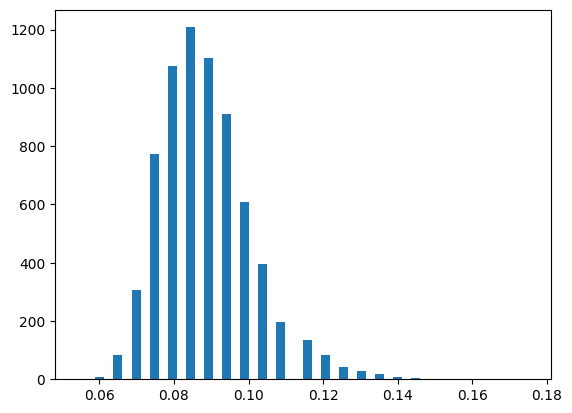

In [27]:
plt.hist(txv_min,bins=50)
plt.show()

In [28]:
# drop similar structures (to validation trajectory) in train trajectory to avoid dataset being biased
txv_difference = 0.05

train_tr = X_train[np.argwhere(txv_min > txv_difference).flat]
train_tr.xyz.shape

(7000, 1565, 3)

In [29]:
train_tr.save_xtc('tmp_train.xtc')
gmx.rms(s=conf,f='tmp_train.xtc',f2='test.xtc',n='backbone.ndx',m='trainxtest_rmsd.xpm')

pod/asmsa-gmx-555-wkztg condition met
              :-) GROMACS - gmx rms, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx rms -s data/p53/eq_nh.pdb -f tmp_train.xtc -f2 test.xtc -n backbone.ndx -m trainxtest_rmsd.xpm

Select group for least squares fit
Group     0 (       Backbone) has   597 elements
There is one group in the index
Select group for RMSD calculation
Group     0 (       Backbone) has   597 elements
There is one group in the index

         that are broken across periodic boundaries, they
         cannot be made whole (or treated as whole) without
         you providing a run input file.

Reading frame    2000 time 200000.000   


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.



Reading frame    6000 time 600000.000   

Will read second trajectory file
Last frame       1500 time 1000000.000   

Building RMSD matrix, 7000x1501 elements
 element  6999; time 699900.00  
RMSD: Min 0.058627, Max 0.446351, Avg 0.219797
                   1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 910
Back Off! I just backed up rmsd.xvg to ./#rmsd.xvg.1#

GROMACS reminds you: "The scientist is not the person who always gives the right answers, he is the one who asks the right questions." (Claude Levi-Strauss)



(0, None, None)

In [30]:
txt = gf.XPM('trainxtest_rmsd.xpm')
txt.array.shape

(7000, 1501)

In [31]:
txt_min = np.min(txt.array,axis=1)
txt_min.shape

(7000,)

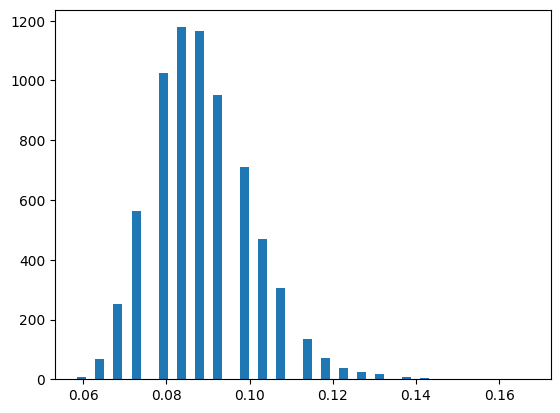

In [32]:
plt.hist(txt_min,bins=50)
plt.show()

In [33]:
# ... one more time with test trajectory & test x validation...
txt_difference = 0.05

x_train = train_tr[np.argwhere(txt_min > txt_difference).flat]
x_train.save_xtc('x_train.xtc')

In [34]:
# test x validation
gmx.rms(f='test.xtc',f2='validate.xtc',s=conf,n='backbone.ndx',m='testxvalidate_rmsd.xpm')

pod/asmsa-gmx-555-wkztg condition met
              :-) GROMACS - gmx rms, 2023.2-plumed_2.10.0_dev (-:

Executable:   /gromacs/AVX2_256_ts/bin/gmx
Data prefix:  /gromacs/AVX2_256_ts
Working dir:  /mnt/ASMSA
Command line:
  gmx rms -f test.xtc -f2 validate.xtc -s data/p53/eq_nh.pdb -n backbone.ndx -m testxvalidate_rmsd.xpm

Select group for least squares fit
Group     0 (       Backbone) has   597 elements
There is one group in the index
Select group for RMSD calculation
Group     0 (       Backbone) has   597 elements
There is one group in the index

         that are broken across periodic boundaries, they
         cannot be made whole (or treated as whole) without
         you providing a run input file.

Last frame       1500 time 1000000.000   

Will read second trajectory file
Reading frame    1000 time 800000.000   


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.



Reading frame    1400 time 840000.000   

Building RMSD matrix, 1501x1500 elements
 element  1500; time 1000000.00  
RMSD: Min 0.056950, Max 0.429559, Avg 0.217343
                   1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 910
Back Off! I just backed up rmsd.xvg to ./#rmsd.xvg.2#

GROMACS reminds you: "Move about like a Scientist, lay down, get kissed" (Red Hot Chili Peppars)



(0, None, None)

In [35]:
txv = gf.XPM('testxvalidate_rmsd.xpm')
txv.array.shape

(1501, 1500)

In [36]:
txv_min = np.min(txv.array,axis=1)
txv_min.shape

(1501,)

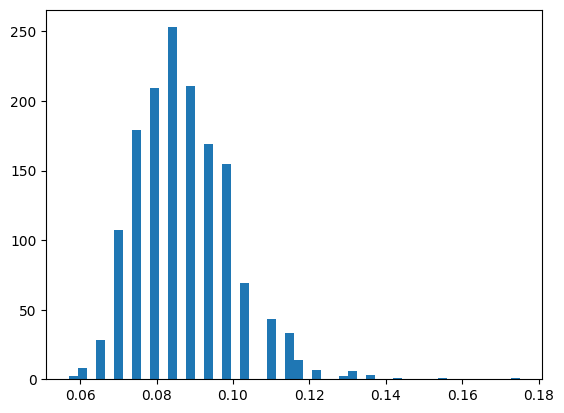

In [37]:
plt.hist(txv_min,bins=50)
plt.show()

In [38]:
# ... one more time with test trajectory & test x validation...
txv_difference = 0.05

x_test = X_test[np.argwhere(txv_min > txv_difference).flat]
x_test.save_xtc('x_test.xtc')

In [39]:
# skip thorough RMS
! ln train.xtc x_train.xtc
! ln test.xtc x_test.xtc

ln: failed to create hard link 'x_train.xtc': File exists
ln: failed to create hard link 'x_test.xtc': File exists


In [9]:
# recovery

x_train = md.load('prepare_data/x_train.xtc', top=conf)
x_test = md.load('prepare_data/x_test.xtc', top=conf)


In [10]:
# get shapes of filtered trajectories that are to be used as datasets
validate_tr = md.load('prepare_data/validate.xtc', top=conf)

trajs = [x_train, validate_tr, x_test]
x_train.xyz.shape, validate_tr.xyz.shape, x_test.xyz.shape

((7000, 1565, 3), (1500, 1565, 3), (1501, 1565, 3))

In [11]:
# reshuffle the geometries to get frame last so that we can use vectorized calculations later on
geoms = [ np.moveaxis(t.xyz,0,-1) for t in trajs]
print ([ g.shape for g in geoms ])

[(1565, 3, 7000), (1565, 3, 1500), (1565, 3, 1501)]


In [44]:
# save geometries

tf.data.Dataset.from_tensor_slices(geoms[0]).save('datasets/geoms/train')
tf.data.Dataset.from_tensor_slices(geoms[1]).save('datasets/geoms/validate')
tf.data.Dataset.from_tensor_slices(geoms[2]).save('datasets/geoms/test')

### Internal coordinates computation

Exercise the ASMSA library on your input. Just check everything appears to work.

There are multiple options that can be combined:
- use traditional internal coordinates (bond distances, angles, and dihedrals) or not
- include additional distances between atoms that may not be bound to express protein folding state more directly
   - dense (all-to-all) atom distances, feasible for very small peptides only
   - sparse atom distances (only some pairs are chosen)
   

We save the computed internal coordinates for training, and a feature extraction model here, therefore everything in the other notebooks should work too.


#### Traditional internal coordinates (all bond distances, angles, and torsions)


In [ ]:

# mol = asmsa.Molecule(conf,topol)

# internal coordinates and sparse any-any atom distances (not restricted to bonds)
# eventually, top (and index) can be left out to use sparse distances only

sparse_dists = asmsa.NBDistancesSparse(geoms[0].shape[0], density=nb_density)
mol=asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[sparse_dists])

# dense distances are feasible for very small (upto 5 residua) peptides only

# dense_dists = asmsa.NBDistancesDense(geom.shape[0])
# mol = asmsa.Molecule(pdb=conf,top=topol,ndx=index,fms=[dense_dists])

#### Alternative: only backbone + Cbeta anlges and dihedrals

In [13]:
with open('prepare_data/backbone.ndx') as i:
    i.readline()
    bb = np.array([ int(j)-1 for j in " ".join(i.readlines()).split() ])

In [14]:
bb

array([   0,    1,   12,   14,   16,   19,   21,   22,   27,   29,   30,
         33,   35,   36,   39,   41,   42,   45,   47,   48,   52,   54,
         56,   59,   61,   62,   65,   67,   68,   74,   76,   77,   83,
         85,   86,   90,   92,   93,  102,  104,  105,  111,  113,  114,
        115,  117,  118,  121,  123,  124,  133,  135,  136,  137,  139,
        140,  148,  150,  151,  159,  161,  162,  167,  169,  170,  171,
        173,  174,  182,  184,  185,  190,  192,  193,  200,  202,  203,
        206,  208,  209,  210,  212,  213,  217,  219,  220,  222,  224,
        225,  231,  233,  234,  237,  239,  240,  244,  246,  247,  251,
        253,  254,  257,  259,  260,  264,  266,  267,  276,  278,  279,
        282,  284,  286,  289,  291,  292,  294,  296,  297,  302,  304,
        305,  310,  312,  313,  319,  321,  322,  327,  329,  330,  338,
        340,  341,  344,  346,  347,  353,  355,  356,  361,  363,  364,
        366,  368,  369,  375,  377,  378,  382,  3

In [15]:
# backbone angles and dihedrals
angles = np.array([ bb[i:i+3] for i in range(0,len(bb)-3) ])
diheds = np.array([ bb[i:i+4] for i in range(0,len(bb)-4) ])
angles, diheds

(array([[   0,    1,   12],
        [   1,   12,   14],
        [  12,   14,   16],
        ...,
        [1548, 1549, 1554],
        [1549, 1554, 1556],
        [1554, 1556, 1557]]),
 array([[   0,    1,   12,   14],
        [   1,   12,   14,   16],
        [  12,   14,   16,   19],
        ...,
        [1546, 1548, 1549, 1554],
        [1548, 1549, 1554, 1556],
        [1549, 1554, 1556, 1557]]))

In [16]:
# XXX: select alpha carbons and matching betas
tr1 = md.load(conf)
cas = tr1.topology.select('name CA and not resname GLY')
cbs = tr1.topology.select('name CB')
assert(len(cas) == len(cbs))

In [17]:
cas

array([   1,   16,   22,   30,   36,   42,   48,   56,   62,   68,   77,
         86,   93,  105,  118,  124,  140,  151,  162,  174,  185,  193,
        203,  213,  220,  225,  234,  240,  247,  254,  260,  267,  279,
        286,  292,  297,  305,  313,  322,  330,  341,  347,  356,  364,
        369,  378,  385,  392,  398,  405,  414,  422,  436,  443,  451,
        457,  465,  472,  479,  489,  496,  507,  514,  525,  530,  538,
        543,  551,  563,  572,  581,  587,  596,  606,  614,  621,  630,
        637,  644,  655,  666,  673,  679,  689,  699,  708,  719,  725,
        731,  739,  745,  757,  765,  771,  778,  784,  793,  803,  811,
        819,  830,  837,  850,  858,  866,  877,  884,  893,  905,  913,
        921,  929,  940,  948,  955,  966,  977,  987,  993, 1000, 1007,
       1015, 1021, 1033, 1043, 1050, 1056, 1065, 1076, 1082, 1090, 1096,
       1103, 1110, 1118, 1128, 1140, 1148, 1160, 1168, 1174, 1182, 1188,
       1194, 1200, 1216, 1224, 1232, 1243, 1255, 12

In [18]:
# indices of CAs (non-GLY) on the backbone
cai = np.argwhere(bb.reshape(1,-1) == cas.reshape(-1,1))[:,1]
cai

array([  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,
        40,  46,  49,  55,  58,  61,  67,  70,  73,  76,  82,  85,  88,
        91,  94,  97, 100, 103, 106, 109, 112, 115, 118, 121, 124, 127,
       130, 133, 136, 139, 142, 145, 148, 151, 154, 157, 160, 163, 166,
       169, 172, 175, 178, 181, 184, 187, 193, 196, 199, 202, 205, 208,
       211, 214, 217, 220, 223, 226, 229, 232, 235, 238, 241, 244, 247,
       250, 253, 256, 259, 262, 265, 268, 271, 274, 277, 280, 283, 286,
       292, 295, 298, 301, 304, 307, 310, 313, 316, 319, 322, 328, 331,
       334, 337, 340, 343, 346, 349, 352, 355, 358, 361, 364, 367, 370,
       373, 376, 379, 382, 385, 388, 391, 394, 397, 400, 403, 409, 412,
       415, 418, 421, 424, 427, 430, 433, 436, 439, 442, 445, 448, 451,
       454, 457, 466, 469, 472, 475, 478, 481, 484, 487, 490, 493, 496,
       499, 502, 505, 508, 511, 517, 520, 523, 529, 532, 535, 538, 541,
       544, 547, 550, 553, 556, 559, 562, 568, 571, 574, 577, 58

In [19]:
# angles of CB-CA-X, where X is the next atom on the backbone
cbangles = np.array([[ cbs[0], cas[0], bb[cai[0]+1] ]] +
                   [[cbs[i], bb[cai[i]], bb[cai[i]-1] ] for i in range(1,len(cbs))])
# just check 
cbangles+1

array([[   3,    2,   13],
       [  18,   17,   15],
       [  24,   23,   22],
       [  32,   31,   30],
       [  38,   37,   36],
       [  44,   43,   42],
       [  50,   49,   48],
       [  58,   57,   55],
       [  64,   63,   62],
       [  70,   69,   68],
       [  79,   78,   77],
       [  88,   87,   86],
       [  95,   94,   93],
       [ 107,  106,  105],
       [ 120,  119,  118],
       [ 126,  125,  124],
       [ 142,  141,  140],
       [ 153,  152,  151],
       [ 164,  163,  162],
       [ 176,  175,  174],
       [ 187,  186,  185],
       [ 195,  194,  193],
       [ 205,  204,  203],
       [ 215,  214,  213],
       [ 222,  221,  220],
       [ 227,  226,  225],
       [ 236,  235,  234],
       [ 242,  241,  240],
       [ 249,  248,  247],
       [ 256,  255,  254],
       [ 262,  261,  260],
       [ 269,  268,  267],
       [ 281,  280,  279],
       [ 288,  287,  285],
       [ 294,  293,  292],
       [ 299,  298,  297],
       [ 307,  306,  305],
 

In [20]:
cbdiheds = np.array([[ cbs[0], cas[0], bb[cai[0]+1], bb[cai[0]+2] ]] +
                   [[cbs[i], bb[cai[i]], bb[cai[i]-1], bb[cai[i]-2]] for i in range(1,len(cbs))])
cbdiheds+1

array([[   3,    2,   13,   15],
       [  18,   17,   15,   13],
       [  24,   23,   22,   20],
       [  32,   31,   30,   28],
       [  38,   37,   36,   34],
       [  44,   43,   42,   40],
       [  50,   49,   48,   46],
       [  58,   57,   55,   53],
       [  64,   63,   62,   60],
       [  70,   69,   68,   66],
       [  79,   78,   77,   75],
       [  88,   87,   86,   84],
       [  95,   94,   93,   91],
       [ 107,  106,  105,  103],
       [ 120,  119,  118,  116],
       [ 126,  125,  124,  122],
       [ 142,  141,  140,  138],
       [ 153,  152,  151,  149],
       [ 164,  163,  162,  160],
       [ 176,  175,  174,  172],
       [ 187,  186,  185,  183],
       [ 195,  194,  193,  191],
       [ 205,  204,  203,  201],
       [ 215,  214,  213,  211],
       [ 222,  221,  220,  218],
       [ 227,  226,  225,  223],
       [ 236,  235,  234,  232],
       [ 242,  241,  240,  238],
       [ 249,  248,  247,  245],
       [ 256,  255,  254,  252],
       [ 2

In [53]:
# just angles
mol=asmsa.Molecule(pdb=conf,n_atoms=geoms[0].shape[0],
                   angles=np.concatenate((angles,cbangles)),
                   diheds=np.concatenate((diheds,cbdiheds)))

In [21]:
# molecule model with explicit angles and dihedrals, and sparse distances from among Calpha and Cbetas
# (don't bother with distances now)
sparse_dists = asmsa.NBDistancesSparse(geoms[0].shape[0], density=nb_density, atoms = np.concatenate((cas,cbs)))
mol=asmsa.Molecule(pdb=conf,n_atoms=geoms[0].shape[0],
                   angles=np.concatenate((angles,cbangles)),
                   diheds=np.concatenate((diheds,cbdiheds)),
                   fms=[sparse_dists]) 

In [22]:
mol_model = mol.get_model()

example_input = torch.randn((*geoms[0].shape[:2],1))

In [23]:
mol_model.angles

array([[   0,    1,   12],
       [   1,   12,   14],
       [   2,    1,   12],
       ...,
       [1550, 1549, 1548],
       [1554, 1556, 1557],
       [1558, 1557, 1556]])

In [24]:
mol_model.get_indices()

{'bonds': (0, 0), 'angles': (0, 780), 'dihed4': (780, 1559)}

In [25]:
sparse_dists.bonds

array([[ 457,  472],
       [ 667,  680],
       [ 551,  563],
       ...,
       [ 765,  314],
       [ 858, 1118],
       [  56,   62]])

#### Save the features (molecule) model

In [ ]:
mol_model = mol.get_model()

example_input = torch.randn((*geoms[0].shape[:2],1))
traced_script_module = torch.jit.trace(mol_model, example_input)

traced_script_module.save('features.pt')

#### Compute the interanal coordinates now

In [60]:
intcoords = [ mol.intcoord(g).T for g in geoms]
print(
    [ g.shape for g in geoms ],
    [ i.shape for i in intcoords ]
)

[(1565, 3, 7000), (1565, 3, 1500), (1565, 3, 1501)] [(7000, 3448), (1500, 3448), (1501, 3448)]


In [61]:
[train,validate,test] = intcoords

In [62]:
# validate the saved model -- should yield nearly 0.

test_from_model = mol_model(torch.from_numpy(geoms[2])).numpy()
np.max(test - test_from_model.T)

0.0

In [63]:
# normalize training set
train_mean = np.mean(train,axis=0)
train -= train_mean
train_scale = np.std(train,axis=0)
train /= train_scale

In [64]:
# normalize test and validation sets
test -= train_mean
test /= train_scale
validate -= train_mean
validate /= train_scale

In [65]:
# save for usage in tune/train/test phase

tf.data.Dataset.from_tensor_slices(train).save('datasets/intcoords/train')
tf.data.Dataset.from_tensor_slices(validate).save('datasets/intcoords/validate')
tf.data.Dataset.from_tensor_slices(test).save('datasets/intcoords/test')

np.savetxt('datasets/intcoords/mean.txt',train_mean)
np.savetxt('datasets/intcoords/scale.txt',train_scale)

### Density of the conformational space

- Sample the training trajectory randomly
- For each point in the trajectory:
  - calculate RMSD to all points in the sample
  - pick some number $n$ of nearest ones
  - calculate the _density_ at this point as $$ d = \sum_{i=1}^n e^{-d_i} / n $$  i.e. the nearer the sample points are, the higher the density
 
Altogether, $d$ roughly corresponds to the probability that the molecule during simulation ends up in this area of the conformational space.

In [ ]:
sample_size = 5000
x_train = md.load('x_train.xtc', top=conf)
tr_sample = x_train[np.random.choice(len(x_train),sample_size,False)]
tr_sample.save('sample.xtc')

In [ ]:
gmx.rms(f='x_train.xtc',f2='sample.xtc',s=conf,n='backbone.ndx',m='sample_rmsd.xpm')

In [ ]:
rms = gf.XPM('sample_rmsd.xpm')

#### Visual check to verify the sample size is representative
- typically, not many distances should be less than 0.1 nm and more than 1 nm 
(the latter depends on the molecule, can be more for e.g. big disordered proteins)
- the histogram should be semi-smooth

In [ ]:
plt.hist(rms.array.flatten(),bins=50)
plt.show()

In [ ]:
k_nearest = 200
rms_sort = np.sort(rms.array.astype(np.float32))
erms = np.exp(-rms_sort[:,:k_nearest])
dens = (np.sum(erms,axis=1)-1.) / (erms.shape[1] - 1)

#### Histogram of densities
- quite high number of points should fall above 0.8, those are low energy basins
- the interval [0.5, 1.0] should be reasonably covered
- on the contrary, too many points below 0.4 would indicate either insufficient sampling above or too sparse trajectory

In [ ]:
plt.hist(dens,bins=20)
plt.show()

In [ ]:
len(dens),len(x_train)

In [ ]:
np.savetxt('datasets/train_density.txt',dens)